In [1]:
# load data
import pandas as pd
from IPython.display import display
import numpy as np

red_wine = pd.read_csv('red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


In [2]:
# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

In [3]:
# Split features and target
# convert to numpy array
X_train = df_train.drop('quality', axis=1).values
X_valid = df_valid.drop('quality', axis=1).values
y_train = df_train['quality'].values
y_valid = df_valid['quality'].values

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)

batch_size = 256
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=batch_size, shuffle=False)

In [5]:
# set the random seed for reproducibility
import random  
import os
def set_all_seeds(seed=1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(1)

In [6]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                model.load_state_dict(self.best_state)

In [7]:
# build a neural network model
import torch.nn as nn
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(11, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.seq(x)
    
# instantiate the model
model = MyModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (seq): Sequential(
    (0): Linear(in_features=11, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [8]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.L1Loss()
early_stopping = EarlyStopping(patience=20, min_delta=1e-5)
num_epochs = 500
history = {'loss': [], 'val_loss': []}

In [9]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='D:/temp/tensorboard_logs_redwine')

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        xb, yb = xb.to(device), yb.to(device)        
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    model.eval()
    with torch.no_grad():
        val_losses = []
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            val_losses.append(loss.item())
        val_loss = np.mean(val_losses)

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {train_loss:.6f} - val_loss: {val_loss:.6f}")

    # 写入TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopped at epoch {epoch+1}")
        break

history_df = pd.DataFrame(history)
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
writer.close()

Epoch 1/500 - loss: 0.300134 - val_loss: 0.128884
Epoch 2/500 - loss: 0.144662 - val_loss: 0.132120
Epoch 3/500 - loss: 0.130434 - val_loss: 0.123060
Epoch 4/500 - loss: 0.124343 - val_loss: 0.132285
Epoch 5/500 - loss: 0.115305 - val_loss: 0.111373
Epoch 6/500 - loss: 0.109943 - val_loss: 0.111157
Epoch 7/500 - loss: 0.108676 - val_loss: 0.101475
Epoch 8/500 - loss: 0.104246 - val_loss: 0.110964
Epoch 9/500 - loss: 0.103882 - val_loss: 0.099194
Epoch 10/500 - loss: 0.100924 - val_loss: 0.104458
Epoch 11/500 - loss: 0.100900 - val_loss: 0.096958
Epoch 12/500 - loss: 0.098120 - val_loss: 0.096970
Epoch 13/500 - loss: 0.097801 - val_loss: 0.103616
Epoch 14/500 - loss: 0.099339 - val_loss: 0.095124
Epoch 15/500 - loss: 0.097404 - val_loss: 0.095163
Epoch 16/500 - loss: 0.093804 - val_loss: 0.106667
Epoch 17/500 - loss: 0.100064 - val_loss: 0.095962
Epoch 18/500 - loss: 0.097723 - val_loss: 0.099778
Epoch 19/500 - loss: 0.100817 - val_loss: 0.107052
Epoch 20/500 - loss: 0.097739 - val_loss

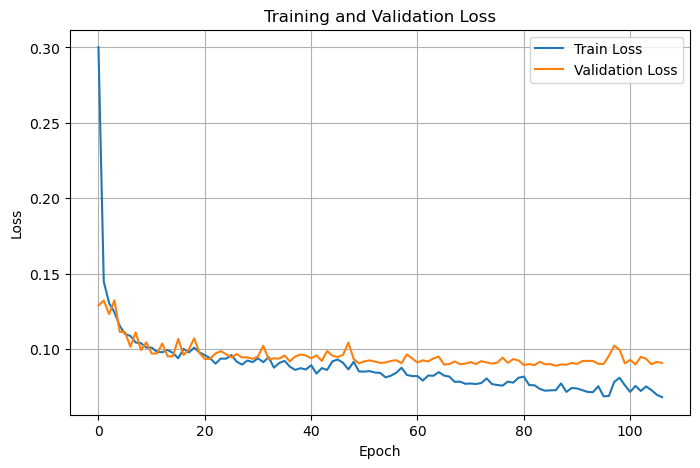

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()